# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

In [ ]:
# !pip install -q tensorflow-gpu==2.0.0-alpha0  #for colab run

     |████████████████████████████████| 332.1MB 50kB/s 
     |████████████████████████████████| 419kB 61.0MB/s 
     |████████████████████████████████| 3.0MB 49.9MB/s 


### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import tensorflow.keras.backend as keras_backend
from tensorflow import keras
tf.keras.backend.set_floatx('float64')
# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import matplotlib as mpl
# mpl.style.use('seaborn')
# from colorama import Fore
# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


In [22]:
# import functions for run

import model, train, train_maml
from sine_generator import SinusoidGenerator 
import generate_dataset, shuffled_batch 
import  eval_sinewave_for_test, copy_model
from eval_sinewave_for_test import eval_sinewave_for_test
from  plot_model_comparison_to_average import plot_model_comparison_to_average
from  compare_maml_and_neural_net import compare_maml_and_neural_net
from save_model_weight import save_model_weight
from load_model_weight import load_model_weight 

colors = {0:'dodgerblue' , 1: 'tomato' , 2:'forestgreen'}

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

# Sinusoid Generator

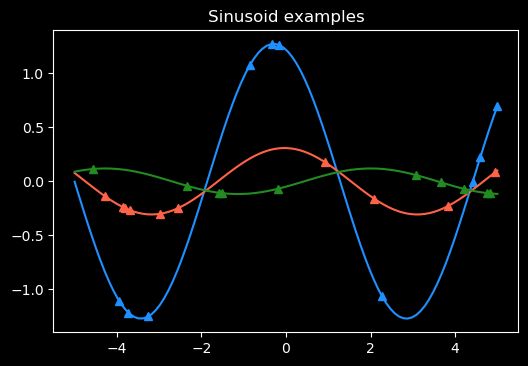

In [11]:
sine_generator = SinusoidGenerator(K=10)

fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(SinusoidGenerator(K=10), fig, title='Sinusoid examples', color=colors[i])


# Generate sinusoid datasets


In [12]:
train_ds, test_ds = generate_dataset.generate_dataset(K=10, test_size=25)
# num_batches = len(train_ds)
train_ds[0]

# Average test dataset

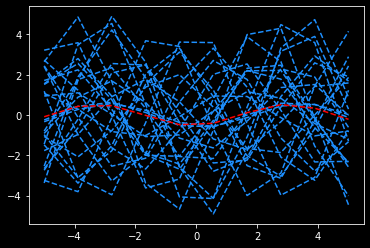

In [13]:
ts_ds = test_ds
# tr_ds, ts_ds = generate_dataset(K=10, test_size=25)
avg_pred =[]
x, _ = SinusoidGenerator(K=10).equally_spaced_samples()  
for i, sinusoid_generator in enumerate(ts_ds):
        _ , y = sinusoid_generator.equally_spaced_samples()
        plt.plot(x, y,'--',color=colors[0])
        avg_pred.append(y)
avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0),'--', color='red')
plt.show()

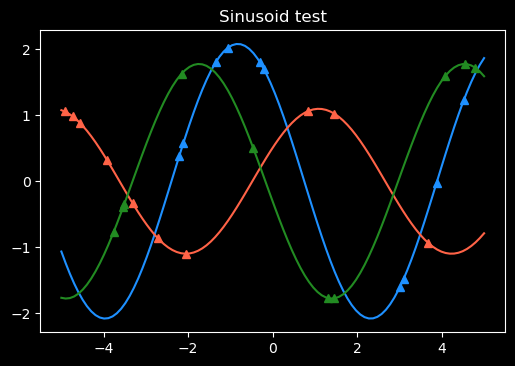

In [14]:
fig = plt.figure(figsize=(6,4), dpi=100)
for i in range(3):

    sine_generator.plot(test_ds[i], fig, title='Sinusoid test', color=colors[i])


# Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [-π, π].

# Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [15]:
from model import SineModel

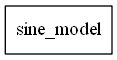

In [8]:
import graphviz
import pydotplus
pydotplus.find_graphviz()
keras.utils.plot_model(SineModel(), show_shapes=True, to_file='model.png')

# Train 

Step 0: loss = 4.588546789318105, Time to run 1000 steps = 13.07 seconds
Step 1000: loss = 4.118162523815075, Time to run 1000 steps = 8.56 seconds
Step 2000: loss = 4.17809405535485, Time to run 1000 steps = 9.06 seconds
Step 3000: loss = 4.170854183779956, Time to run 1000 steps = 9.22 seconds
Step 4000: loss = 4.167862276309578, Time to run 1000 steps = 10.11 seconds
Step 5000: loss = 4.180807924382304, Time to run 1000 steps = 9.62 seconds
Step 6000: loss = 4.20016636517035, Time to run 1000 steps = 8.62 seconds
Step 7000: loss = 4.195566513999511, Time to run 1000 steps = 8.36 seconds
Step 8000: loss = 4.208527414302451, Time to run 1000 steps = 8.16 seconds
Step 9000: loss = 4.21309189523185, Time to run 1000 steps = 9.45 seconds
Step 10000: loss = 4.216347938726004, Time to run 1000 steps = 10.03 seconds
Step 11000: loss = 4.226874819540618, Time to run 1000 steps = 9.09 seconds
Step 12000: loss = 4.235597670453395, Time to run 1000 steps = 9.67 seconds
Step 13000: loss = 4.2641

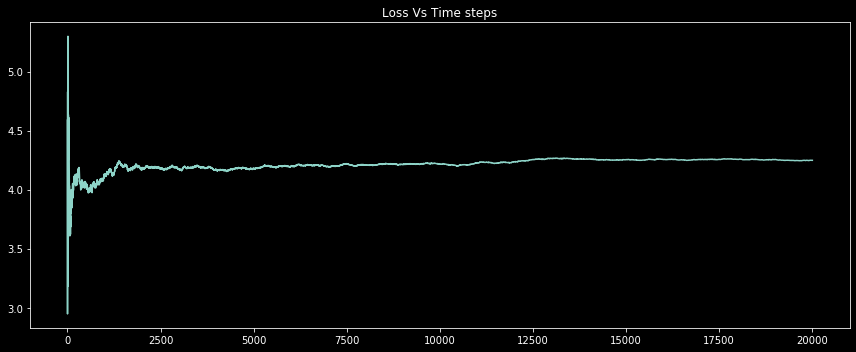

In [9]:
sine_model = SineModel()
neural_net = train.train_model(sine_model, train_ds)
# neural_net = train.train_model_shuffled(train_ds)

### A neural network trained for this task, should converge to the average of the sinusoids curves.

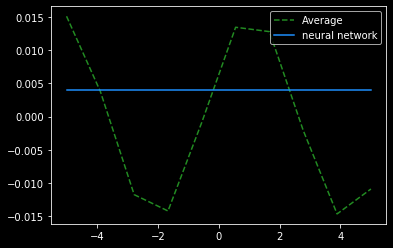

In [18]:
plot_model_comparison_to_average(model=neural_net, ds=train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

### Try to use transfer learning for different sine waves

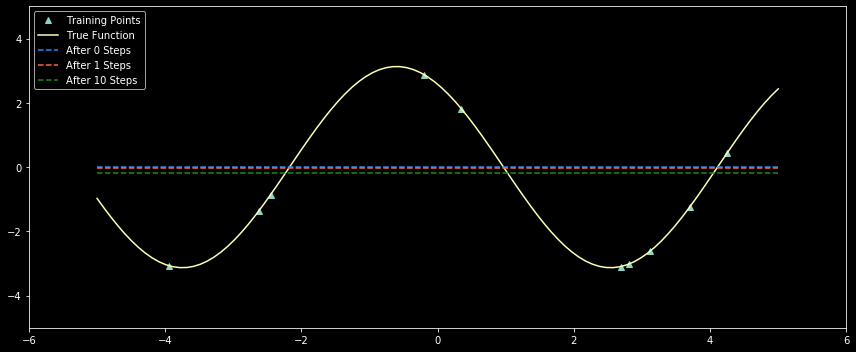

In [26]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    fit_res, w3_copied_model = eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

## Training MAML

It should take around 40 seconds to train for 1000 steps.

In [29]:
sine_model = SineModel()
maml = train_maml.train_maml(sine_model, 1, train_ds)

Step 1000: loss = 3.9940965170323115, Time to run 1000 steps = 54.49134564399719
Step 2000: loss = 3.919972248949525, Time to run 1000 steps = 55.90759086608887
Step 3000: loss = 3.918587658579582, Time to run 1000 steps = 54.94699716567993
Step 4000: loss = 3.9544825239769863, Time to run 1000 steps = 55.4428334236145
Step 5000: loss = 3.9072846418552816, Time to run 1000 steps = 55.56051993370056
Step 6000: loss = 3.696340131912992, Time to run 1000 steps = 54.73572325706482
Step 7000: loss = 3.5094283845453385, Time to run 1000 steps = 54.83844757080078
Step 8000: loss = 3.3478172265094983, Time to run 1000 steps = 55.060858964920044
Step 9000: loss = 3.2087207934939697, Time to run 1000 steps = 55.03093433380127
Step 10000: loss = 3.1085337602978407, Time to run 1000 steps = 54.35660219192505
Step 11000: loss = 3.0037563154187246, Time to run 1000 steps = 54.91424870491028
Step 12000: loss = 2.9179133964854804, Time to run 1000 steps = 54.71181893348694
Step 13000: loss = 2.8418862

##  MAML model: compare average


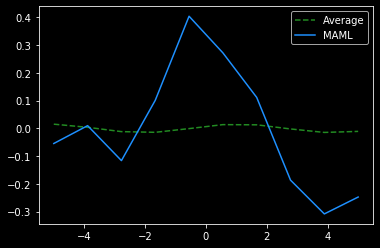

In [30]:
plot_model_comparison_to_average(maml, train_ds, model_name='MAML')

# Use MAML model to fit new sine wave

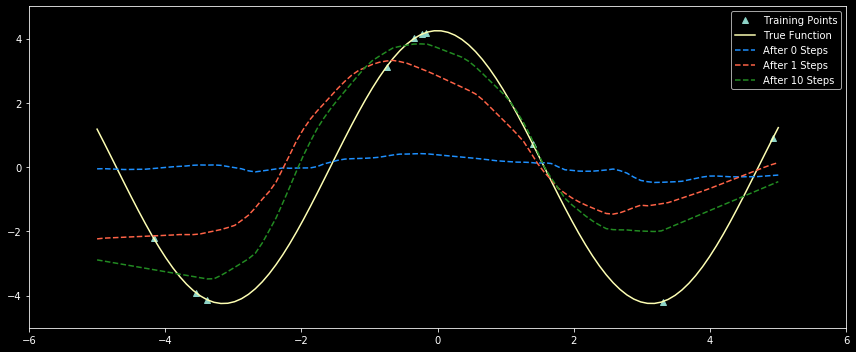

In [31]:
for index in np.random.choice(len(test_ds), size=1, replace=False):
    eval_sinewave_for_test(maml, test_ds[index])

# Save Model

In [42]:
save_model_weight(neural_net, path="./net/neural_net_model")
save_model_weight(maml, path="./maml/maml_model")

# Load Model

In [43]:
sinusoid_generator = SinusoidGenerator(K=10)
x, _ = sinusoid_generator.batch()
neural_net = load_model_weight(SineModel(), path="./net/neural_net_model", x=x)
maml = load_model_weight(SineModel(), path="./maml/maml_model", x=x)

print(neural_net.out.get_weights()[0].shape)
print(maml.out.get_weights()[0].shape)

(40, 1)
(40, 1)


# MAML vs Regular Neural Network

MAML


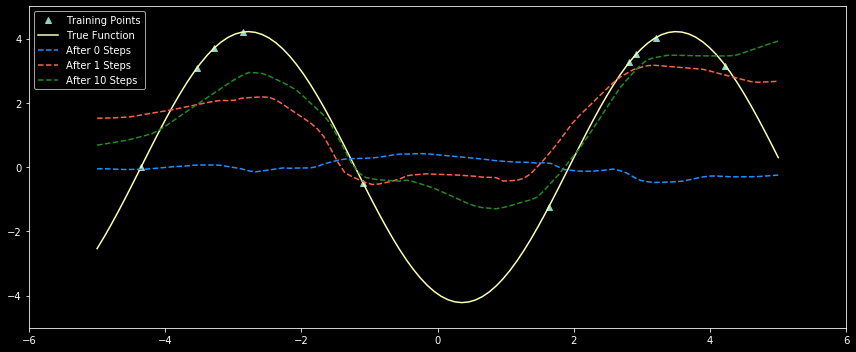

Neural Net


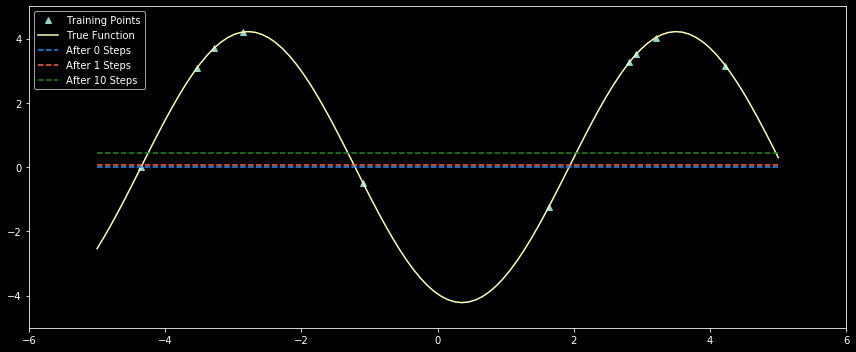

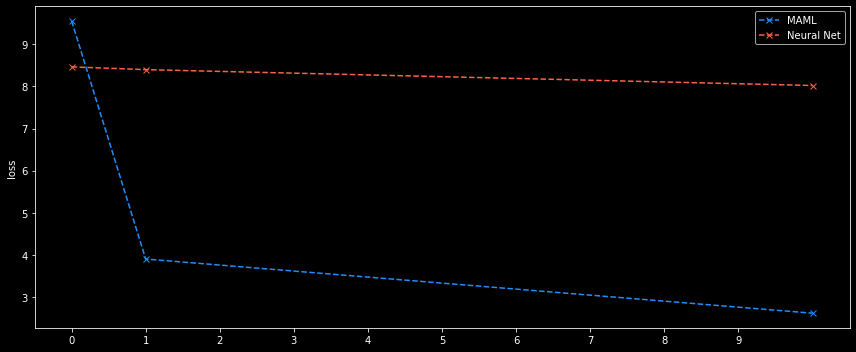

In [32]:
for _ in range(1):
    index = np.random.choice(range(len(test_ds)))
    w3_maml_model, w3_net_model = compare_maml_and_neural_net(maml, neural_net, test_ds[index])

## weights of last layer of  models during fine-tuning

In [33]:
for i in range(len(w3_maml_model)):
    print(f'regular {i+1}:\n {w3_net_model[i]}, \nmaml {i+1}:\n{w3_maml_model[i]}')

regular 1:
 [[-0.16189428]
 [-0.01889101]
 [-0.00442847]
 [-0.0463557 ]
 [ 0.10543217]
 [ 0.18987447]
 [-0.22662352]
 [-0.2667524 ]
 [-0.23642232]
 [ 0.02583953]
 [ 0.02051044]
 [-0.10912575]
 [ 0.01180814]
 [-0.00937034]
 [-0.09526523]
 [-0.14657068]
 [ 0.00358247]
 [-0.09149908]
 [-0.02378909]
 [ 0.02870678]
 [ 0.00176848]
 [-0.04647551]
 [-0.13400098]
 [-0.00464107]
 [-0.06516845]
 [-0.00888917]
 [-0.00963492]
 [-0.00559542]
 [-0.03038252]
 [-0.28313985]
 [-0.17550406]
 [-0.00182359]
 [-0.11262243]
 [-0.11438182]
 [ 0.05398627]
 [-0.06071462]
 [ 0.11273722]
 [ 0.16406001]
 [-0.0029782 ]
 [-0.0089663 ]], 
maml 1:
[[ 0.05028184]
 [-0.36227744]
 [-0.35522442]
 [ 0.32838759]
 [-0.52841804]
 [-0.86210228]
 [-0.04454714]
 [ 0.62904647]
 [ 0.47720399]
 [-0.78404276]
 [ 0.44888221]
 [-0.08390771]
 [-0.24915878]
 [-0.41957411]
 [ 0.82306225]
 [ 0.19781356]
 [-0.02484844]
 [ 0.33597542]
 [ 1.11515478]
 [ 1.34777952]
 [ 0.5831345 ]
 [ 0.39479697]
 [-0.89735672]
 [-0.08660024]
 [ 0.49522676]
 [

# Difference of weights before fine-tuning and after

In [34]:
w3 = neural_net.out.get_weights()[0]
# print(neural_net.out.get_weights())
for i in range(len(w3_net_model)):

    print(f'regular:\n {w3 - w3_net_model[i]}')

regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
regular:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [35]:
w3_maml = maml.out.get_weights()[0]
for i in range(len(w3_maml_model)):

    print(f'maml:\n {w3_maml - w3_maml_model[i]}')

maml:
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
maml:
 [[-4.03709453e-02]
 [-6.08639568e-03]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.54667292e-04]
 [ 1.75399121e-03]
 [ 0.00000000e+00]
 [-1.08213920e-02]
 [-2.59156932e-02]
 [ 0.00000000e+00]
 [-2.52243239e-03]
 [ 0.00000000e+00]
 [-6.28458828e-03]
 [-1.08184909e-03]
 [ 1.86870926e-03]
 [ 0.00000000e+00]
 [-8.02215979e-02]
 [ 4.59168595e-04]
 [ 1.10126248e-03]
 [ 3.63833686e-04]
 [-5.83830613e-04]
 [-1.72804233e-03]
 [-1.28066711e-02]
 [-6.96032673e-02]
 [ 0.00000000e+00]
 [-3.16256992e-02]
 [-1.63558756e-02]
 [-1.09427550e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-4.06123722e-03]
 [-1.68536114e-02]
 [-5.51972591e-03]
 [ 3.55531252e-04]
 [-2.54794576e-03]
 [-8.66756212e-03]
 [-1.58303947e-03]
 [-3.59622831e-03]
 [-2.87711025e-05]
 [-4

n:
 [4. 1. 7. 5. 6. 4. 9. 2. 0. 2.] 
bin:
 [-1.07363221 -0.83149104 -0.58934986 -0.34720869 -0.10506752  0.13707365
  0.37921483  0.621356    0.86349717  1.10563834  1.34777952]

 bin with most amount 0.3792148254090504
n:
 [4. 1. 7. 5. 6. 4. 9. 2. 0. 2.] 
bin:
 [-1.07398774 -0.8318474  -0.58970706 -0.34756671 -0.10542637  0.13671397
  0.37885431  0.62099465  0.863135    1.10527534  1.34741568]

 bin with most amount 0.3788543126967576
n:
 [4. 1. 7. 5. 6. 4. 9. 2. 0. 2.] 
bin:
 [-1.08359584 -0.84049469 -0.59739354 -0.35429239 -0.11119123  0.13190992
  0.37501107  0.61811222  0.86121338  1.10431453  1.34741568]

 bin with most amount 0.37501107106044773


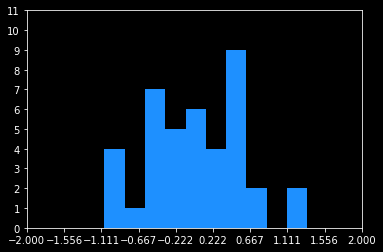

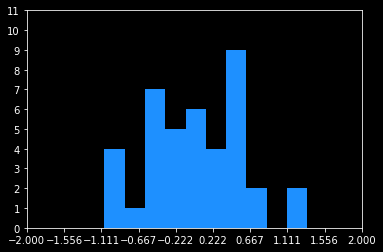

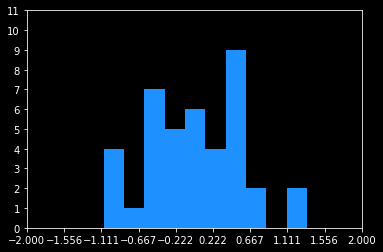

In [36]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml_model[i], facecolor='dodgerblue')
    plt.xticks(np.linspace(-2,2,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

n:
 [ 0.  0.  0.  0.  0. 40.  0.  0.  0.  0.] 
bin:
 [-0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5]

 bin with most amount 0.0
n:
 [ 1.  1.  0.  1.  1.  1.  1.  2.  4. 28.] 
bin:
 [-0.0802216  -0.07201257 -0.06380354 -0.05559451 -0.04738548 -0.03917644
 -0.03096741 -0.02275838 -0.01454935 -0.00634032  0.00186871]

 bin with most amount -0.006340321460586579
n:
 [ 1.  1.  1.  1.  0.  1.  3.  7. 18.  7.] 
bin:
 [-0.09726837 -0.08599191 -0.07471545 -0.06343899 -0.05216253 -0.04088607
 -0.02960961 -0.01833315 -0.00705669  0.00421977  0.01549623]

 bin with most amount -0.007056692081822136


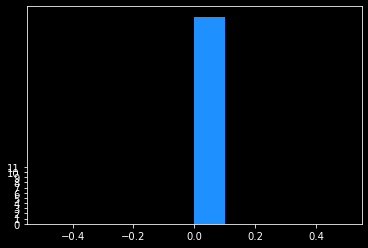

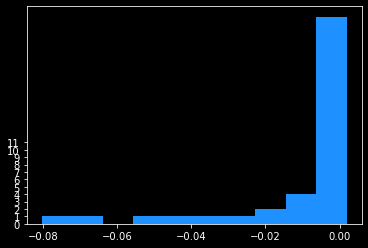

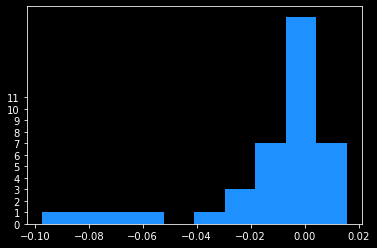

In [37]:
for i in range(len(w3_maml_model)):
    fig = plt.figure(i)
    data = plt.hist(w3_maml - w3_maml_model[i], facecolor='dodgerblue')
#     plt.xticks(np.linspace(-0.1,0.1,10))
    plt.yticks(np.arange(0,12))
    n ,bin_ = data[0], data[1]
    print('n:\n', n,'\nbin:\n', bin_)
    print('\n bin with most amount', bin_[np.argmax(n)])

![alt text](https://miro.medium.com/max/585/1*WmG_R90SyXjWwu6qPfwtQQ.png)